In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('darkgrid')

# Task 1
Find the roots of square equation by gradient descent
x**2 - 6 * x + 4 = 0

Представим уравнение в виде функции и возведём её в квадрат:
<br>
$y = x^2-6x+4$
$y$_$new$$=(x^2-6x+4)^2$

Тогда точки минимума для новой функции $y$_$new$ будут нулями (корнями уравнения при y=0) исходной функции $y$.

Визуализируем:

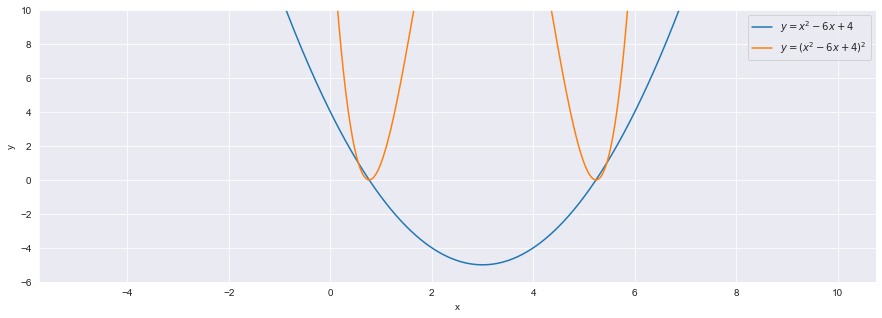

In [2]:
# исходная функция
def f(x):
    return x ** 2 - 6 * x + 4


# квадрат исходной функции
def sqr_f(x):
    return f(x) ** 2


# значение производной функции f в точке x_0
def grad(f, x_0, delta=1.0e-5):
    return (f(x_0 + delta) - f(x_0)) / delta


x = np.linspace(-5, 10, 1000)
y_1 = f(x)
y_2 = sqr_f(x)

plt.figure(figsize=(15, 5))
plt.plot(x, y_1, label='$y=x^2-6x+4$')
plt.plot(x, y_2, label='$y=(x^2-6x+4)^2$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.ylim([-6, 10]);

In [3]:
def find_minimum(start, n_steps, learning_rate):
    history = [start]
    for _ in range(n_steps):
        start -= learning_rate * grad(sqr_f, start)
        history.append(start)
    return history

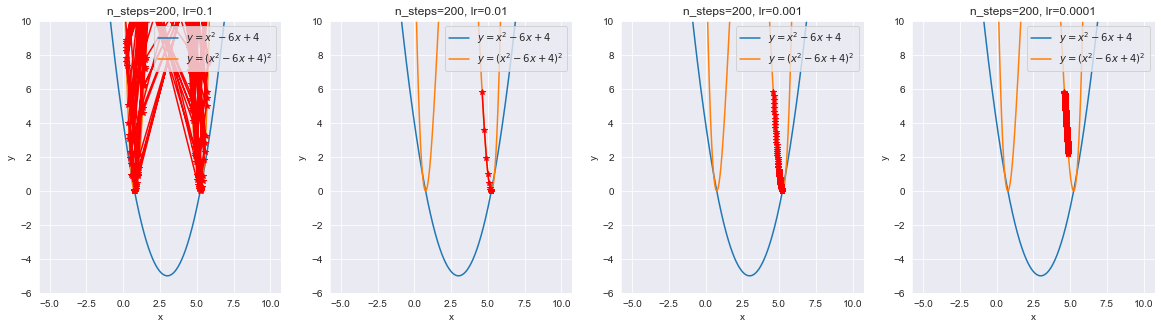

In [8]:
x_start = np.random.choice(x)
n_steps = 200

fig, ax = plt.subplots(1, 4, figsize=(20, 5), sharex='row')
for i, lr in enumerate([0.1, 0.01, 0.001, 0.0001]):
    finding_history = np.array(find_minimum(x_start, n_steps, lr))
    ax[i].plot(x, y_1, label='$y=x^2-6x+4$')
    ax[i].plot(x, y_2, label='$y=(x^2-6x+4)^2$')
    ax[i].plot(finding_history, sqr_f(finding_history), marker='*', color='red', alpha=1)
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_ylim([-6, 10])
    ax[i].set_title(f'n_steps={n_steps}, lr={lr}')
    ax[i].legend()

Вывод:
1) Сходимость алгоритма в данной реализации зависит от следующих параметров:
 - выбор начальной точки $x$_$start$
 - значения $learning$_$rate$
 - количество шагов $n$_$steps$
Видно, что если зафиксировать начальную точку и количество шагов и проварьировать параметр $learning$_$rate$, то могут быть случаи:
 - $learning$_$rate$ слишком большой и мы фактически расходимся (1 график)
 - $learning$_$rate$ оптимален для того схождения (2 и 3 графики)
 - $learning$_$rate$ слишком маленький, алгоритм не успевает сойтись (4 график)

2) Чтобы найти второй корень, лучше переделать реализацию алгоритма, т.е. лучше в качестве критерия остановки алгоритма использовать не количество шагов, а изменение значения производной (с небольшим lr) - если её изменение мало (например не превышает 0.001), то считаем, что мы попали в локальный минимум, запоминаем данную точку. Затем повторяем несколько раз для разны начальных точек, чтобы найти другие минимумы.

# Task 2
Realize forward and backward pass for LinearLayer with activation

In [3]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))


def sigmoid_backward(x):
    sig = sigmoid(x)
    return sig * (1 - sig)


def relu(x):
    return np.maximum(0., x)


def relu_backward(x):
    return np.where(x > 0, 1, 0)


def mse_loss(t, y):
    return (t - y) ** 2


def d_mse_loss(t, y):
    return 2 * (y - t)

In [4]:
class LinearLayer:
    def __init__(self, n_inp, n_out, activation='sigmoid', bias=True):
        # почитав литературу, увидел более "элегантное решение"
        # лучше создать дополнительный признак, для bias, который всегда будет равен 1
        # и расширить матрицу весов
        # таким образом 1 нейрон будет задаваться вектором-столбцом вида (w_1, w_2, w_3, ..., w_n, b), где
        # n - число признаков объекта (нейронов с предыдущего слоя), b - bias (смещение) для нейрона
        self.bias = bias
        self.w = np.random.randn(n_inp + 1 if bias else n_inp, n_out) * 0.1

        if activation == 'sigmoid':
            self.activ = sigmoid
        elif activation == 'relu':
            self.activ = relu
        elif activation == 'None':
            self.activ = None
        else:
            raise Exception(f'Unknown activation function "{activation}"')

        self._clear_state()

    def _clear_state(self):
        self.inp = None
        self.out = None
        self.d_w = None
        self.d_b = None

    def forward(self, x):
        if self.bias:
            # generate feature with 1 for bias
            bias = np.ones((len(x), 1))
            self.inp = np.hstack([x, bias])
        else:
            self.inp = x

        self.out = self.inp @ self.w                              # Y = X*W
        activ = self.activ(self.out) if self.activ else self.out  # Z = F(X*W)=F(Y)
        return activ

    def backward(self, prev_grad):
        # prev_grad = dL/dZ, where L - loss, Z - output from this layer
        # full_grad = dL/dZ * dZ/dY * dY/dW
        # find grad_f = dZ/dY, where Y = X*W + B
        if self.activ == sigmoid:
            grad_f = sigmoid_backward(self.out)
        elif self.activ == relu:
            grad_f = sigmoid_backward(self.out)
        else:
            grad_f = prev_grad

        # grad_w = dY/dW = X, then dL/dW = prev_grad * grad_f * X

        print(f'prev_grad shape {prev_grad.shape}')
        print(f'grad_f shape {grad_f.shape}')
        print(f'self.inp shape {self.inp.shape}')

        self.d_w = prev_grad @ grad_f.T @ self.inp

        # next_grad = dL/dZ * dZ/dY * dY/dX)
        next_grad = grad_f @ self.w.T

        # так как мы должны рассчитать градиент по каждому из входов в текущий слой, то необходимо
        # теперь уже удалить добавленный признак (необходимый для bias), который равен 1.
        return next_grad[:, :next_grad.shape[1] - 1]

In [6]:
model = LinearLayer(n_inp=4, n_out=10)

inp = np.random.rand(10, 4)
after_model = model.forward(inp)
after_model, after_model.shape

(array([[0.51159967, 0.45142923, 0.53268669, 0.50129375, 0.51459483,
         0.49570809, 0.47136309, 0.52425949, 0.49150651, 0.45777446],
        [0.50170877, 0.4399545 , 0.53602729, 0.48669113, 0.51075761,
         0.48844148, 0.49304734, 0.52029389, 0.52765309, 0.45202921],
        [0.50184234, 0.48429386, 0.50457205, 0.46428985, 0.55575331,
         0.48356843, 0.50437309, 0.48322498, 0.55287241, 0.4515137 ],
        [0.518542  , 0.45336528, 0.51290127, 0.48852508, 0.54635581,
         0.50626957, 0.47003354, 0.48428462, 0.51491564, 0.44458162],
        [0.52778982, 0.46410969, 0.51733253, 0.50363738, 0.52247197,
         0.51371098, 0.47145312, 0.50543482, 0.51757251, 0.45644198],
        [0.5228477 , 0.48278677, 0.51740895, 0.49966148, 0.5137884 ,
         0.50479831, 0.48833898, 0.51787383, 0.53392845, 0.46596619],
        [0.4945527 , 0.48362533, 0.50707635, 0.45887653, 0.55704161,
         0.47534418, 0.50915673, 0.48573618, 0.55196006, 0.4514463 ],
        [0.52258682, 0.5009

In [45]:
from typing import Tuple

class Model:
    def __init__(self, arch: Tuple[Tuple[int, int]], activation):
        self.layers = []
        for i, p in enumerate(arch):
            self.layers.append(
                LinearLayer(n_inp=p[0], n_out=p[1], activation=activation if i < len(arch) - 1 else 'None')
            )
        self._clear_state()

    def _clear_state(self):
        for layer in self.layers:
            layer._clear_state()

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

# Task 3
Realize SGD Momentum optimizer

In [46]:
class SGDMomentum:
    def __init__(self, model: Model, lr=0.0001, momentum=0.99):
        self.model = model
        self.lr = lr
        self.m = momentum
        self.vel = [np.zeros_like(layer.w) for layer in self.model.layers]

    def step(self):
        for i, layer in enumerate(self.model.layers):
            print(layer)
            print(layer.d_w.shape)
            self.vel[i] = self.m * self.vel[i] - layer.d_w
            layer.w += self.lr * self.vel[i]

    def zero_grad(self):
        self.model._clear_state()

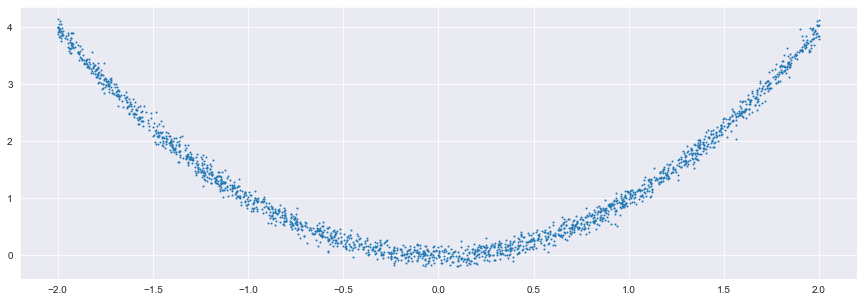

In [47]:
x = np.random.uniform(-2, 2, 2000)
y = x**2 + np.random.randn(x.shape[0])*0.1

plt.figure(figsize=(15, 5))
plt.scatter(x, y, s=1);

In [48]:
x.shape, y.shape

((2000,), (2000,))

In [49]:
model = Model(((1, 5), (5, 1)), activation='relu')
pred = model.forward(np.array([[1], [2]]))
model.backward(np.array([[1], [1]]))

prev_grad shape (2, 1)
grad_f shape (2, 1)
self.inp shape (2, 6)
prev_grad shape (2, 5)
grad_f shape (2, 5)
self.inp shape (2, 2)


array([[0.05526899],
       [0.05514128]])

In [50]:
model.layers[0].w, model.layers[0].d_w

(array([[ 0.06331028,  0.01711985,  0.00394095,  0.08386801,  0.05326591],
        [ 0.06731893,  0.02529973,  0.13436221, -0.12089805,  0.03537741]]),
 array([[0.16702492, 0.11137171],
        [0.16702492, 0.11137171]]))

In [52]:
model.layers[1].w, model.layers[1].d_w

(array([[ 0.04353393],
        [ 0.19136035],
        [ 0.00759511],
        [-0.00460401],
        [-0.01473441],
        [ 0.04023639]]),
 array([[0.32456869, 0.101959  , 0.28054727, 0.04683796, 0.23055254,
         2.        ],
        [0.32456869, 0.101959  , 0.28054727, 0.04683796, 0.23055254,
         2.        ]]))

In [39]:
model = Model(((1, 5), (5, 1)), activation='relu')
optim = SGDMomentum(model)

for e in range(20):
    for i, (val, t) in enumerate(zip(x, y)):
        optim.zero_grad()
        pred = model.forward(np.array([val])[:, np.newaxis])
        loss = mse_loss(t, pred)
        grad = d_mse_loss(t, pred)

        print(pred)
        print(loss)
        print(grad)

        model.backward(grad)
        optim.step()


[[-0.03292079]]
[[3.6572083]]
[[-3.82476577]]
(1, 2)


ValueError: operands could not be broadcast together with shapes (2,5) (1,2) 

In [13]:
model = LinearLayer(n_inp=2, n_out=2)
model.w = np.array([[0.2, 0.1], [0.3, 0.1], [1, 1]])

x = np.array([[5, 3], [4, 6], [1, 2], [3, 4]])

frw = model.forward(x)
frw

array([[0.94784644, 0.85814894],
       [0.97340301, 0.88079708],
       [0.85814894, 0.78583498],
       [0.94267582, 0.84553473]])

In [33]:
np.array([x[0]])[:, np.newaxis].shape

(1, 1)